In [1]:
from requests.sessions import Session
from requests import request
from requests.compat import urljoin
from bs4 import BeautifulSoup
import re

In [2]:
url = 'https://lms.sunde41.net'
resp = request('GET', url)
dom = BeautifulSoup(resp.text, 'html.parser')

In [3]:
form = dom.select_one('form')
form.attrs

{'action': '/auth/login', 'method': 'POST', 'name': 'login_user_form'}

In [4]:
for el in form.select('input[name]'):
	print(el.attrs['name'])

next
email
password
remember


In [85]:
from json import load

with open('lms.json', 'r', encoding='utf8') as fp:
    lms = load(fp)

In [86]:
resp = request(form.attrs['method'], urljoin(url, form.attrs['action']),
        data={'email':lms['id'], 'password':lms['pw']})

In [87]:
resp.headers['set-cookie']

'NID_JST=qXeDAxAwb9D1pzAqFRSwp1XiC8yJFanRzMORV+acgvgEIjDx2wOZ59FtqoVI9h/EHeUL4tXI2MhHpuppjwvRX6Rb1QWicXfFlhU4lG9z479vbt6KTbJrXYp7116/qUu4hCU1KjgvZ4ikat5Z4WWDviXtLIJUXVr3j5Qyxvo9nLQ=; expires=Mon, 06-Oct-2025 03:07:56 GMT; path=/; domain=.nid.naver.com; Secure; SameSite=Lax; HttpOnly'

In [88]:
re.search(r'<title>.+?</title>', resp.text)

<re.Match object; span=(852, 876), match='<title>네이버 : 로그인</title>'>

In [89]:
resp = request('get', 'https://lms.sunde41.net/course/8')
re.search(r'<title>.+?</title>', resp.text)

<re.Match object; span=(305, 342), match='<title>로그인 : 고려대학교 지능정보SW아카데미</title>'>

In [90]:
resp.headers['set-cookie'].split(';')[0].split('=')

['session', 'KX8ba6md44d6dvxvwnfSadrFggaPoYJRUHs1541vhaQ']

In [91]:
c = {resp.headers['set-cookie'].split(';')[0].split('=')[0]:
     resp.headers['set-cookie'].split(';')[0].split('=')[1]}

In [92]:
resp1 = request('get', 'https://lms.sunde41.net/course/8')
re.search(r'<title>.+?</title>', resp1.text)

<re.Match object; span=(305, 342), match='<title>로그인 : 고려대학교 지능정보SW아카데미</title>'>

In [93]:
s = Session()

In [94]:
for k,v in c.items():
    s.cookies.set(k,v)

In [95]:
s.cookies.get_dict()

{'session': 'KX8ba6md44d6dvxvwnfSadrFggaPoYJRUHs1541vhaQ'}

In [96]:
resp2 = s.request('get', 'https://lms.sunde41.net/course/8')
re.search(r'<title>.+?</title>', resp2.text)

<re.Match object; span=(305, 342), match='<title>로그인 : 고려대학교 지능정보SW아카데미</title>'>

In [97]:
# 크롤러 구조만 있는 ver
URLs = ['https://lms.sunde41.net/course/8'] # seed
Seens = []

# 도메인 제한(간단)
domain = re.compile(r'lms.sunde41.net') # 여기에 있는 애들만

while URLs:
    seed = URLs.pop(0) #앞에서부터 순차적으로 추가
    Seens.append(seed)

    #resp = request('get', seed, cookies=c) # 관리자 권한 때문에
    resp = request('get', seed)
    
    if resp.status_code != 200:
        continue

    dom = BeautifulSoup(resp.text, 'html.parser')

    for a in dom.select('a[href]'):
        nurl = urljoin(seed, a['href'])
        if nurl not in URLs and nurl not in Seens and domain.search(nurl):
            URLs.append(nurl)

In [ ]:
# 스크래핑 구조 추가한 ver
URLs = ['https://lms.sunde41.net/course/8'] # seed
Seens = []

# 도메인 제한(간단)
domain = re.compile(r'lms.sunde41.net') # 여기에 있는 애들만

while URLs:
    seed = URLs.pop(0) #앞에서부터 순차적으로 추가
    Seens.append(seed)

    #resp = request('get', seed, cookies=c) # 관리자 권한 때문에
    resp = request('get', seed)
    
    if resp.status_code != 200:
        continue

    dom = BeautifulSoup(resp.text, 'html.parser')
    
    # Scraping (수업자료 => 앞부분 path가 동일)
    for a in dom.select('a[href]'):
        nurl = urljoin(seed, a['href'])
        if nurl not in URLs and nurl not in Seens and domain.search(nurl):
            URLs.append(nurl)

In [23]:
# 챗cpt ver
import re
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

seed_url = 'https://lms.sunde41.net/course/8'
URLs = [seed_url] 
Seens = []

# 도메인 제한: lms.sunde41.net 도메인만 크롤링
domain = re.compile(r'lms\.sunde41\.net')

while URLs:
    seed = URLs.pop(0)
    Seens.append(seed)
    
    resp = requests.get(seed)
    if resp.status_code != 200:
        continue

    dom = BeautifulSoup(resp.text, 'html.parser')
    
    for a in dom.select('a[href]'):
        nurl = urljoin(seed, a['href'])
        # 중복 검사 및 도메인 제한
        if nurl not in URLs and nurl not in Seens and domain.search(nurl):
            # PDF 파일인지 확인
            if nurl.lower().endswith('.pdf'):
                pdf_resp = requests.get(nurl)
                if pdf_resp.status_code == 200:
                    # URL에서 파일 이름 추출 (예: report.pdf)
                    filename = os.path.basename(nurl)
                    # 파일 저장 (바이너리 모드)
                    with open(filename, 'wb') as f:
                        f.write(pdf_resp.content)
                    print(f"Downloaded PDF: {filename}")
                else:
                    print(f"PDF 다운로드 실패: {nurl}")
            else:
                URLs.append(nurl)


In [98]:
url = 'https://lms.sunde41.net/static/uploads/lectures/8/Database.pdf'

In [99]:
resp = request('get', url) # Cookie X
resp.headers['content-type']

'application/pdf'

In [100]:
re.search(r'application/(pdf)', resp.headers['content-type']).group(1)

'pdf'

In [103]:
with open(re.search(r'.+/(.+)$', url).group(1), 'wb') as fp:
    fp.write(resp.content)

In [104]:
!ls -al *.pdf
# !dir /w *.pdf

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [108]:
resp2 = s.request('get', 'https://lms.sunde41.net/qna/new/8')
re.search(r'<title>.+?</title>', resp2.text)

<re.Match object; span=(305, 342), match='<title>로그인 : 고려대학교 지능정보SW아카데미</title>'>

In [109]:
dom = BeautifulSoup(resp2.text, 'html.parser')

In [112]:
form = dom.select_one('form')
form.attrs['action'], form.attrs['method']

('/auth/login', 'POST')

In [111]:
for el in form.select('[name]'):
    print(el.name, el.attrs['name'])

input next
input email
input password
input remember


#### **여기부터 실행하면 경고 메일 날라감(실행x)**

In [29]:
url = 'https://lms.sunde41.net/qna/detail/80' #질문게시판 글
resp = s.request('get', url)
dom = BeautifulSoup(resp.text, 'html.parser')
form = dom.select_one('form')
form.attrs['action'], form.attrs['method']

('/auth/login', 'POST')

In [30]:
form.select('[name]')

[<input id="next" name="next" type="hidden" value="/qna/detail/80"/>,
 <input autocomplete="email" class="form-control" name="email" placeholder="이메일을 입력하세요" type="email"/>,
 <input autocomplete="off" class="form-control" name="password" placeholder="비밀번호를 입력하세요" type="password"/>,
 <input checked="" class="form-check-input" name="remember" type="checkbox"/>]

In [31]:
form.select_one('[name]').attrs['name']

'next'

In [32]:
s.request(form.attrs['method'], url, data={'desciption':'테스트'})

<Response [200]>

In [33]:
url = 'https://lms.sunde41.net/qna/detail/80' #질문게시판 글
resp = s.request('get', url)
dom = BeautifulSoup(resp.text, 'html.parser')

## 네이버

In [113]:
s.cookies.clear()

url = 'https://nid.naver.com/nidlogin.login?mode=form&url=https://www.naver.com/'
resp = s.request('get', url)
dom = BeautifulSoup(resp.text, 'html.parser')

In [114]:
form = dom.select_one('form') #항상 폼을 찾아봐요
form.attrs['action'], form.attrs['method']

('https://nid.naver.com/nidlogin.login', 'POST')

In [115]:
for el in form.select('[name]'):
	print(el.name, el.attrs['name'], el.attrs['value'] if el.has_attr('value') else None)

input localechange 
input dynamicKey fbekLF74MjPQF-SZ8HgpnOjLjMb7-ilDGrZ4cH6bl7R4ZA5Bqzsv6G_Kv4OJSI173OqMNJxBIlT4lVTlZlE7YlcYTD30Szt4ytVy-8sXxn8
input encpw 
input sessionKey 
input show_pk true
input wtoken 
input svctype 1
input bvsd 
input locale ko_KR
input url https://www.naver.com/
input enctp 1
input next_step false
input fbOff true
input smart_LEVEL 1
input encnm 
input id 
input pw None
input nvlong off


In [116]:
# F12 -> Application -> coolies 긁어오기
c = '''
BUC	mjYztpgjb7Y2jXe3lXYJXa2OmvcGFultPxA3CDMJ7eM=	.naver.com	/	2026-04-24T01:51:11.836Z	47	✓	✓	None		Medium	
NAC	w5yjBUgn1YTB	.naver.com	/	2026-04-24T01:50:58.654Z	15		✓	None		Medium	
NACT	1	.naver.com	/	2025-03-21T01:50:58.928Z	5					Medium	
NID_AUT	IphEIFeidZDAYlsMY2cqIHvN8G9rJ25/C+2YZcfqQq8UtZwgya6dInlb1Jg/pDa8	.naver.com	/	Session	71	✓	✓	Lax		Medium	
NID_JKL	0ecdnBbOhOt3eWG0qrgZqeY3YYnlcFf/U0Ce68L8BoU=	.naver.com	/	Session	51		✓			Medium	
NID_SES	AAABrT2FqO7BjeuBqiujtdFDyt5WQhRkXrEQU92ejeMEieYFBSYwbMo897UNECwc7+po7l7jezRDWnsDhh5A56lSDnI37rDcdXRpQEOYE/7OD1LyLLckBuc59ryAAu9DvszvgpXZhOYU4Pk3L6Q9w770AGarr9S0Djl+jmkZkl4uuMl0qrAlBrLJ69j7XgEJoOXvUnE5+JmSm5XpP/Q+Z2UQau6bvF3nidCU9sfNj9hiRPqVbiKtJyCXPaHThoKO55+YI+B5KPCRN98k0JTFpTwk3UdWJXOaaAnmDk8dPHFl4r0/TWzkmSvmVWh0xAtKM3+9Z4NXZnpTu1QbTibDarxEuANK2fXw7eHy3DixVv6ar9iSIKqFos7xRrk60lheKgeRQi316KXNgo6kCT08FIXgR0dVbemK0pzZwYD41tupc0zzXuXhIZsIiDwT4AikDVUJPY1zScW2ecI20F/kgptVWrEl0p8QajetxB9Owj/w37M7OMgnw/UOzaXV+Gl54z8OW/LVrito+Cq/VDM4VUOmNU+986rbOfe2RbltlVKFkrqkIPEl5hZnpZX9NBUCHULx5w==	.naver.com	/	Session	591		✓	Lax		Medium	
NM_srt_chzzk	1	www.naver.com	/	2025-03-21T01:50:58.000Z	13					Medium	
NNB	A26Q4AHFFYBGO	.naver.com	/	2026-04-24T01:51:11.835Z	16		✓	None		Medium	
PM_CK_loc	5b3cfba8eee6debe05f5d6bd00f0cae50ee57d51f5a67cde955dd5130f89fee9	www.naver.com	/	2025-03-21T01:50:58.251Z	73	✓				Medium	
SRT30	1742435459	.naver.com	/	2025-03-20T02:21:11.836Z	15		✓	None		Medium	
SRT5	1742435459	.naver.com	/	2025-03-20T01:56:11.836Z	14		✓	None		Medium	
nid_inf	1920014581	.naver.com	/	Session	17					Medium	
'''

In [117]:
cookies = dict()
for line in c.splitlines():
    if len(line) > 0:
        cookies[line.split()[0]]=line.split()[1]   

In [118]:
url = 'https://mail.naver.com'
re.search(r'<title>(.+)</title>', request('get', url).text).group(1)

'네이버 : 로그인'

In [119]:
re.search(r'<title>(.+)</title>', request('get', url, cookies=cookies).text).group(1)

'메일'

In [120]:
# 받은메일함
url = 'https://mail.naver.com/v2/folders/0' # 여기에 메일이 있어야 돼요
resp = request('get', url, cookies=cookies)
re.search(r'<title>(.+)</title>', resp.text).group(1)

'메일'

In [121]:
url = 'https://mail.naver.com/json/list'
params = {
    'folderSN': '0', # 0 받은편지함, 5 스팸메일함
    'page': '1',
    'viewMode': 'time',
    'previewMode': '1',
    'sortField': '1',
    'sortType': '0',
    'u': 'ajh970425'
}

resp = request('POST', url, params=params, cookies=cookies)
resp.headers['content-type']

'text/plain;charset=UTF-8'

In [55]:
for mail in resp.json()['mailData']:
    print(mail['subject'])

비로그인 계정의 휴면 전환 안내
[지니뮤직] 서비스 이용약관 개정 안내 (개정일: 3월 26일)
[야놀자] 서비스 이용 약관 및 개인정보 처리방침 개정 안내
안지현님 해촉증명서
[트리플] 서비스 이용 약관 및 개인정보 처리방침 개정 안내
OPIc개인정보이용내역 통지 안내
anjihyeon527@gmail.com 관련 보안 경고
anjihyeon527@gmail.com 관련 보안 경고
[인터파크] 서비스 이용 약관 및 개인정보 처리방침 개정 안내
[인터파크커머스] 인터파크 쇼핑/도서 서비스명 변경 안내
RE: 제로베이스 특강 자료
해피포인트 비밀번호 변경 안내
[해피포인트] 지금 고객님의 소멸 예정 포인트를 확인하세요!
어학시험 온라인 접수 내역
[이화이언] 서비스 종료 위기, 여러분의 도움이 필요합니다.
답변
[텀블벅] 이용약관 및 개인정보처리방침 개정, 프리오더 이용약관 신설 사전 안내
2025년2월26일
2025.02.25
톡서랍 플러스 정기결제가 완료되었습니다.
[길벗출판사] 휴면 계정이 자동 탈퇴 처리될 예정입니다.
티머니 01월 거래내역 및 T마일리지 적립/소멸 안내
[국민건강보험공단] 건강검진표 및 안내문 알림
[고려대학교 지능정보 SW아카데미] 6기 오리엔테이션 안내 (2025.02.28)
안지현님께서 안지현님께 졸업증명서(을)를 전송하셨습니다.
고려대학교 지능정보 SW아카데미 6기 최종 합격자 안내
고려대 지능정보 SW아카데미 6기 지필면접
고려대학교 지능정보 SW아카데미 서류전형 합격 및 면접 안내
ㅋㅋ
블리 일어났어?


In [122]:
params['folderSN'] = 5
resp = request('POST', url, params=params, cookies=cookies)
resp.headers['content-type']

'text/plain;charset=UTF-8'

In [123]:
for mail in resp.json()['mailData']:
    print(mail['subject'])

🛍️Vous pouvez encore profiter des 6 Jours 
[뉴발란스] 개인정보 이용내역 안내
(광고)안지현님이 기다리던 열교환기 수치해석의 마지막 퍼즐! 지금 확인하세요!
(광고)[기간 한정] 물량 절감을 위한 최적의 솔루션! 안지현님, 파격 할인가로 만나보세요!
(광고)[추가모집] 오늘만! 안지현님이 놓친 인기 CAE 교육! 마지막 신청 기회!
(광고) 오직! 여기서만 &quot;차량렌탈비 1개월+푸짐한 차량용품 지원&quot; 전국 1등서비스에 도전합니다.
벚꽃 같은 인생
(광고)아빠와 함께하는 시간이 최고입니다


---
## [구글]

In [126]:
s.cookies.clear() #세션 지우고

headers = {
	'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36'
}

url = 'https://www.google.com'

resp = s.get(url, headers=headers)
re.search(r'<title>(.+)</title>', resp.text).group(1)

'Google'

In [127]:
s.cookies.get_dict()

{'AEC': 'AVcja2cz_Ff4k7FD0hd9XvGFUGM5b3hRJd-hU5rQPwpFY6jg1_kItm2FUrQ',
 'NID': '522=faKdNwp4oP_1ad54YKW3Xa9ZL9nk47i7t5SoOdgIFQmgksXlo-umXjAV39BGl0YUK1sXk3ftE1k5dXcfyaXCFfrlMmHErzxnB9mkdjFnVz4GRPQbHPYkfBQeBhy92qEP1Sj1N_nf_rRBoOfQBn3ATwiVb8dpGYs5rt8Uec5Rvawq-aQTvz4u4UhqP1tIMw8m2u0_u5kSpVaA3pcF4A'}

In [128]:
resp = s.get(url+'/search', params={'q':'카리나'}, headers=headers)
re.search(r'<title>(.+)</title>', resp.text).group(1)
# 이거 하면

'Google Search'

In [129]:
resp.url

'https://www.google.com/search?q=%EC%B9%B4%EB%A6%AC%EB%82%98'

-  network -> headers -> request header -> cookie
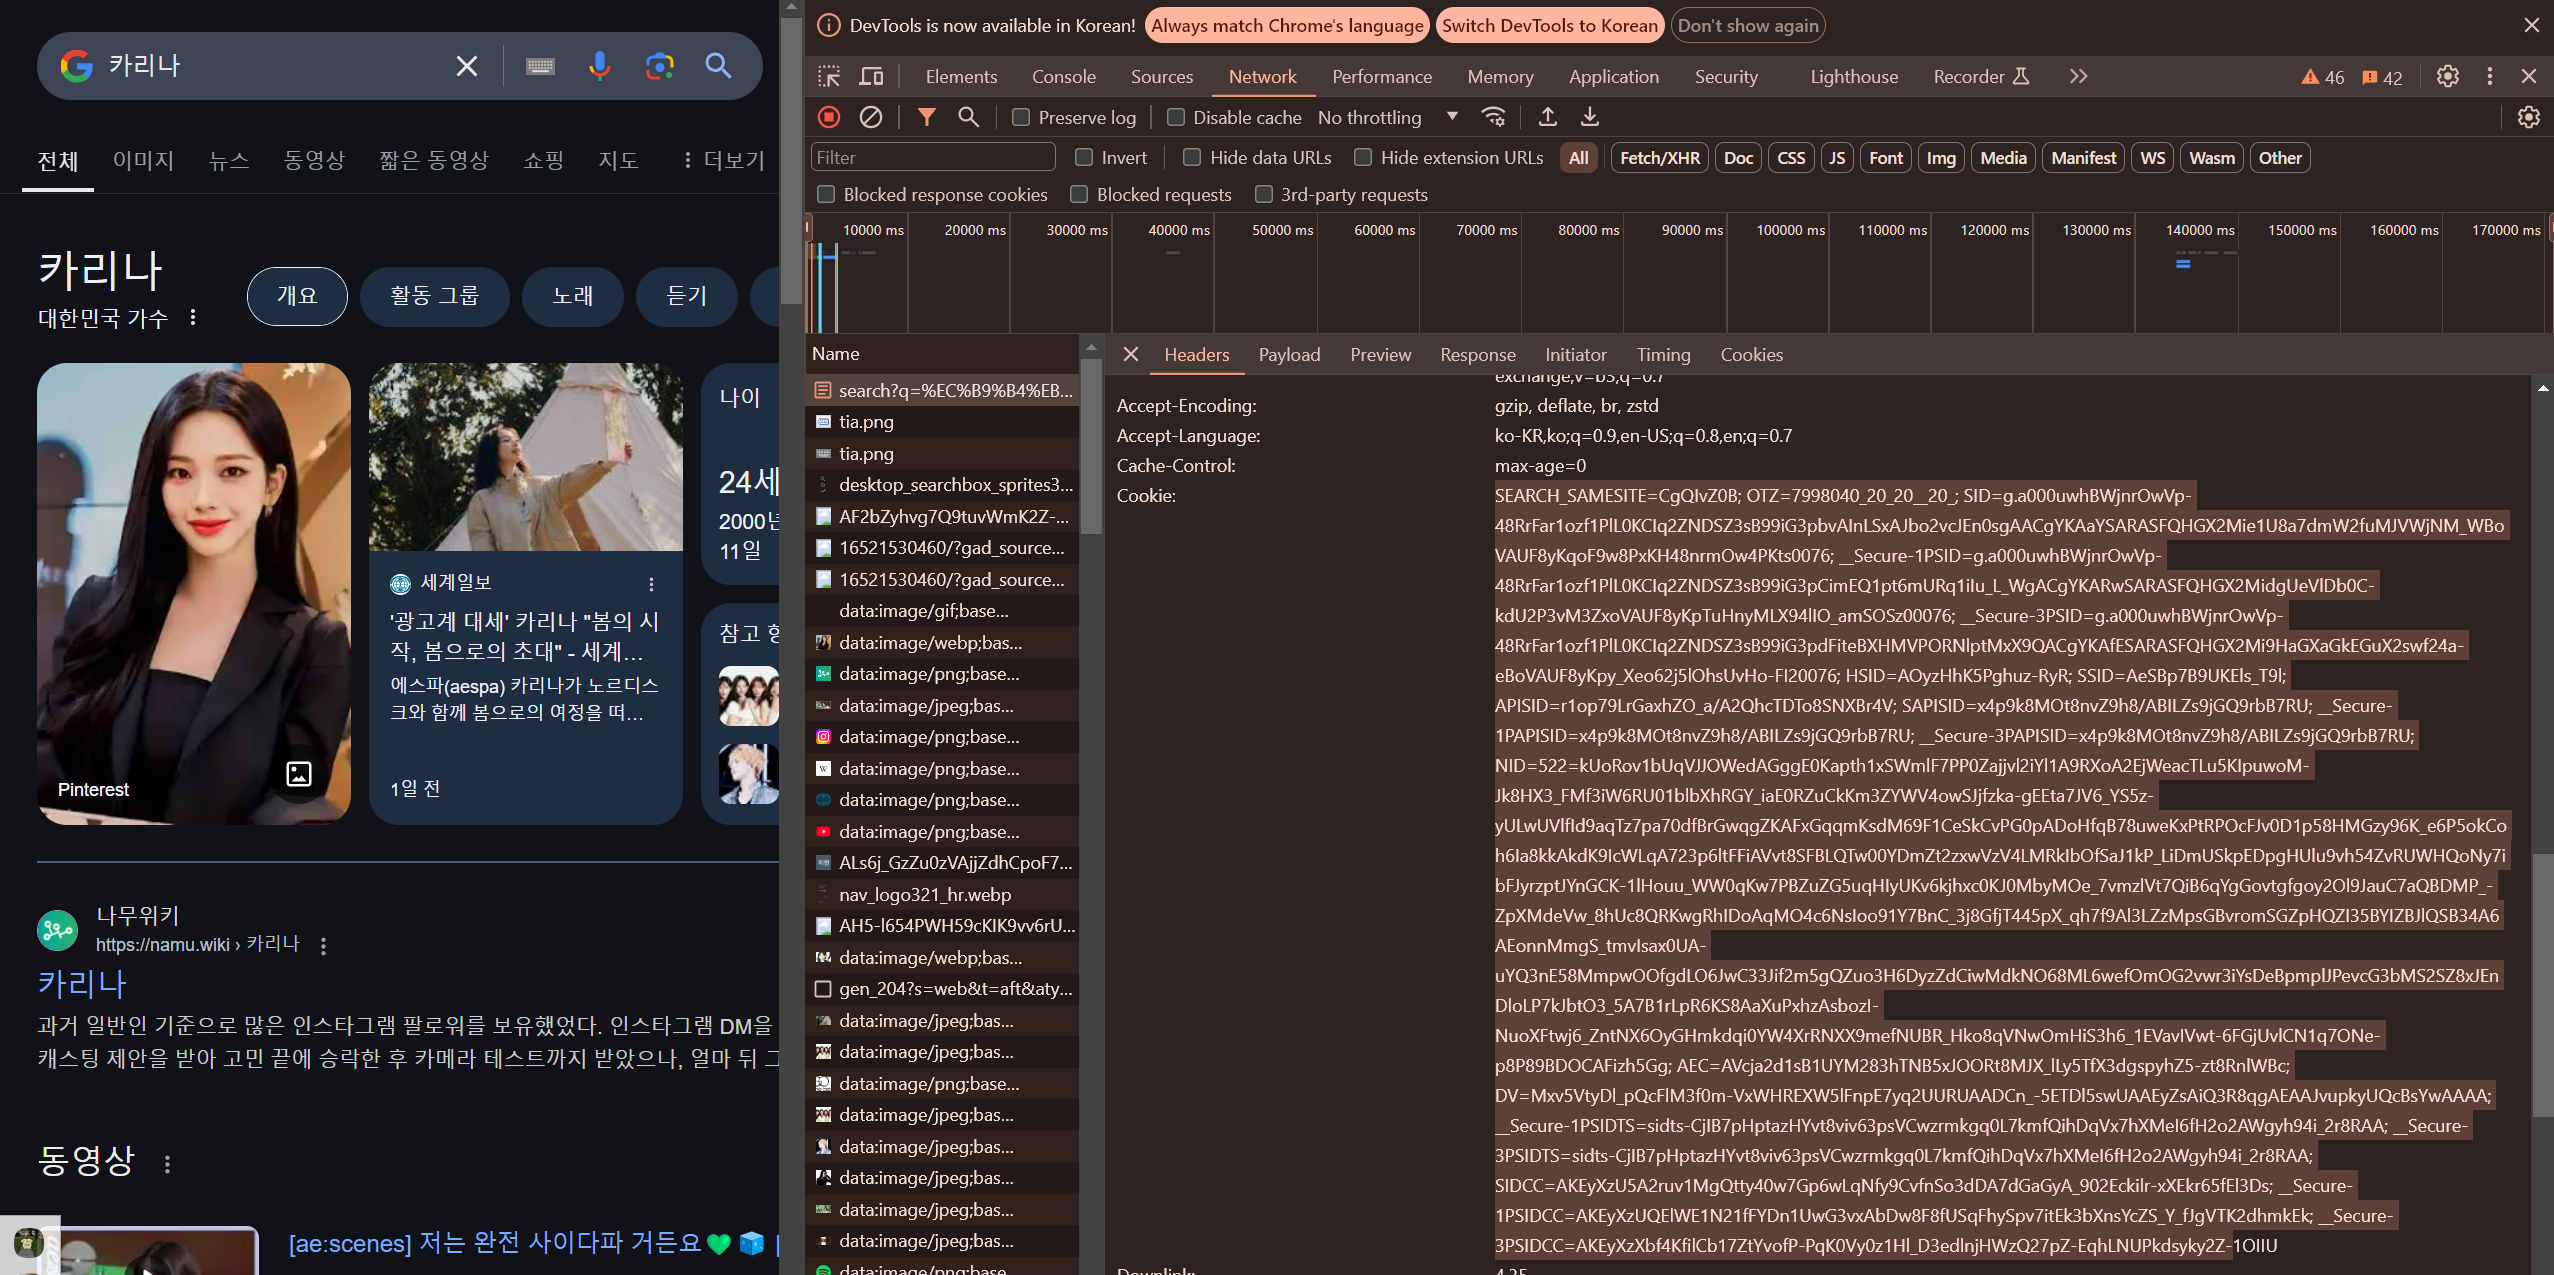

In [73]:
c = '''
AEC	AVcja2d4ERTX_QNr-H5JWiKV6niRlasjBlXftjVcsh8hZyKezyhZECe3s3Y	.google.com	/	2025-04-29T00:55:38.375Z	62	✓	✓	Lax		Medium	
AID		.googleadservices.com	/	2010-01-01T00:00:00.485Z	3	✓		Medium	
APISID	cHmp82X2Tkp3OvqH/A1W7_SkTP4ov01SYw	.youtube.com	/	2026-03-14T06:16:30.532Z	40					High	
APISID	cHmp82X2Tkp3OvqH/A1W7_SkTP4ov01SYw	.google.com	/	2026-04-13T23:55:56.524Z	40					High	
DV	45g-aapFBd0rUKi9Y6BwZZL7uFYXW1nPXDQbbbYoOQIAAAA	www.google.com	/	2025-03-20T03:00:18.000Z	49					Medium	
HSID	A-XCQripptm5a-BYB	.youtube.com	/	2026-03-14T06:16:30.532Z	21	✓				High	
HSID	A2iUmBqq4oNo028H2	.google.com	/	2026-04-13T23:55:56.524Z	21	✓				High	
LOGIN_INFO	AFmmF2swRQIhAKzOXPmlM7aMdSgdhENGyrq2AmqYrrPrq37IZw4mfgrfAiAY_gA6unLPd9YjX39yCXwsMobhftoRsSjNEkCVCPK28Q:QUQ3MjNmeTNqRE9yQ1hsWWRRMTBvS2ZBeDlOZzFoWVo1S3BjYkdWZGtxMGVsQnhPb2RfRnhxdW1Fc3pfWFpWc3V0VklTZ2x6eW0xMExpbzdwTlNGOGtPdWMyX0tvZkJJd0wxSFQ4M2VhdWgxX2pPYWdSR0NLNUF1VXh3V296M1Z5RGhrWV9JSkFWU2h3aS1HMTkwMUE3RnJuTEhnWkFDZjJ3	.youtube.com	/	2026-03-14T06:16:38.951Z	329	✓	✓	None		Medium	
NID	522=h52-ih0DihcAEn-znpnAzEViMhL7f6hIjn40phD8l1bAH723JTgWqIzDo-g9JpQQ5xa4fjHfExXaqGMWLZ0pd2etToRTmymQ-WxXMJOmZEMrQ6Jt3Mr4LX6rho0Bqtj20nEfpUKGg_VSFDR4LoQVDCRZy43D2VEUtPR8kHWQKQK-biOmk8FIk3n2ium7fPNgta8nDVWUO4Eo-psU0_lXahiq7i7jjW8J9jbGdZtaSuY2IzDrTDL4k5wGlDrp5Hlg__Cxj_R5hsLULSjHRKZsWqf38OS5g0zXb8bGtt08_XVYt1yoVmiXQq3UOuxCZ5zTi1pBVfkXVqMAnTT5Gh7Kpkba5_tDMm_Cnx3lfVPoESRCWxjNnBWGBIlZyxASvf_atWUcP13_or-Hw_Owcbju4gMBAyt1FyB7nCEkpNPD50WTZjQ-rxRUGTVXU_o01q2FfS6QU23tzoHKdf8B6x1R1MtaiYY6av8H0ZeU0tAcGpsBB7W6v8z5o8SdTAXtjbZbJunKms1p5C4IWIiIn34PoWGBaIKioQMfVWFqwGPd5XTCDM9z2sY5SjMipPx7zzZEg2vU3p2dhMeI0Wo45_L8hU-kdDoc0MBG5Pc9ygS0k8wL4KUWQDLKgcQvXmtW1Etj0BBZ	.google.com	/	2025-09-19T02:45:15.037Z	651	✓	✓	None		Medium	
SAPISID	h7D1RCHzM2ZJdQ0d/Anoi8MxmmdIVOKImD	.google.com	/	2026-04-13T23:55:56.524Z	41		✓			High	
SAPISID	h7D1RCHzM2ZJdQ0d/Anoi8MxmmdIVOKImD	.youtube.com	/	2026-03-14T06:16:30.532Z	41		✓			High	
SID	g.a000ugho8j0XUYiHeqcwx-OZ7gk_IVXI7vbez38Sixv84EGa7VG5G4DMmTmR3V-1fQbXMuqX3wACgYKAYUSARISFQHGX2MiWvd29czwQx9m7uSttfV7MBoVAUF8yKqyIMMzdpDNg9PhbPNOuWug0076	.google.com	/	2026-04-13T23:55:56.525Z	156					High	
SID	g.a000tQho8gN4S3qjRGRoKLjofBYwagmh6a9WDuS7-sB5J9R8caiavxe9rsjjfMLSPdLun2tengACgYKAd0SARISFQHGX2MiKJ4oC2Su8MfgXheSlqb0BRoVAUF8yKq-NtPOPUTouzdmtPYjQK5a0076	.youtube.com	/	2026-03-14T06:16:30.532Z	156					High	
SIDCC	AKEyXzXtGjMTlnIzPuJSJGDtsy3v6OLjAWJvqiGP4sMyVvtO4dXYJdnVBBX9XoZ7F6n-aZTURl8	.youtube.com	/	2026-02-07T06:35:08.248Z	80					High	
SIDCC	AKEyXzUW3YBWQev_y0pPxQ4MEt1MT-XImPf8Qp06Cwxyx624YDQyJyu1N6_7C2bNT-9F_627AZqD	.google.com	/	2026-03-20T02:50:18.378Z	81					High	
SNID	ACT1_oPjdRqteCNK6ffg3EtztWi0eCMFLOG5Eh5cSFuJap6-qGlsFV1awtwpqOF8Yf-cG-auRmaSY7AHHQ4ho1yaX3SU6sF7C2w	.google.com	/verify	2025-09-19T02:44:53.622Z	103	✓	✓	Lax		Medium	
SSID	AQF1gqP9q8s8gfwxf	.youtube.com	/	2026-03-14T06:16:30.532Z	21	✓	✓			High	
SSID	AW_t7iirIv4hwFQ7A	.google.com	/	2026-04-13T23:55:56.524Z	21	✓	✓			High	
VISITOR_INFO1_LIVE	obYuJsegkkQ	.youtube.com	/	2025-09-07T06:19:43.660Z	29	✓	✓	None		Medium	
VISITOR_INFO1_LIVE	obYuJsegkkQ	.youtube.com	/	2025-09-16T02:50:18.710Z	29	✓	✓	None	https://google.com	Medium	
VISITOR_PRIVACY_METADATA	CgJLUhIEGgAgGw%3D%3D	.youtube.com	/	2025-09-16T02:50:18.710Z	44	✓	✓	None	https://google.com	Medium	
VISITOR_PRIVACY_METADATA	CgJLUhIEGgAgGw%3D%3D	.youtube.com	/	2025-09-07T06:19:43.660Z	44	✓	✓	None		Medium	
YSC	UNzoxeWqj8g	.youtube.com	/	Session	14	✓	✓	None	https://google.com	Medium	
__Secure-1PAPISID	h7D1RCHzM2ZJdQ0d/Anoi8MxmmdIVOKImD	.youtube.com	/	2026-03-14T06:16:30.532Z	51		✓			High	
__Secure-1PAPISID	h7D1RCHzM2ZJdQ0d/Anoi8MxmmdIVOKImD	.google.com	/	2026-04-13T23:55:56.524Z	51		✓			High	
__Secure-1PSID	g.a000tQho8gN4S3qjRGRoKLjofBYwagmh6a9WDuS7-sB5J9R8caiau_WZgkb2Ab2JCzH_5eUHaQACgYKAbUSARISFQHGX2MipJhDQ33UvlB3TnKwrPhVgRoVAUF8yKpBnTHis5DC1htCi1DIn31O0076	.youtube.com	/	2026-03-14T06:16:30.532Z	167	✓	✓			High	
__Secure-1PSID	g.a000ugho8j0XUYiHeqcwx-OZ7gk_IVXI7vbez38Sixv84EGa7VG5N191v8RFnX-QiafQeMjYMgACgYKAfoSARISFQHGX2MiwUdQuAGp77LNDRfpuDG8NhoVAUF8yKq5ZCqLietvKq9qBCLVn06l0076	.google.com	/	2026-04-13T23:55:56.525Z	167	✓	✓			High	
__Secure-1PSIDCC	AKEyXzV0e6Condy9VhYJUWjgFhTvrJ9Heef54-OI-Co52ao8uZutPnMBF4h8SXwmKsH0ayFsyD0	.google.com	/	2026-03-20T02:50:18.378Z	91	✓	✓			High	
__Secure-1PSIDCC	AKEyXzXmv8qgrezSxrcLdbmRtrFhi7-EPD9LYM7DSD10abzwGa_wmyzUbCXS8_LQdRrdPLG_eQ	.youtube.com	/	2026-02-07T06:35:08.248Z	90	✓	✓			High	
__Secure-1PSIDTS	sidts-CjIBEJ3XV3ziafSF-hzzfQILh3p-_UCU4QXa_OKO9nUyavkkJpLvjjZjQi3bHz0By0-mGRAA	.youtube.com	/	2026-02-07T06:34:28.851Z	94	✓	✓			High	
__Secure-1PSIDTS	sidts-CjIB7pHptUK0uccbV6K8gM-XJ2YvGFci7zaJ0fd1xFxs63xevMgq8escWHiUBJH4NGTawxAA	.google.com	/	2026-03-20T02:45:00.757Z	94	✓	✓			High	
__Secure-3PAPISID	h7D1RCHzM2ZJdQ0d/Anoi8MxmmdIVOKImD	.google.com	/	2026-04-13T23:55:56.524Z	51		✓	None		High	
__Secure-3PAPISID	h7D1RCHzM2ZJdQ0d/Anoi8MxmmdIVOKImD	.youtube.com	/	2026-03-14T06:16:30.532Z	51		✓	None		High	
__Secure-3PSID	g.a000tQho8gN4S3qjRGRoKLjofBYwagmh6a9WDuS7-sB5J9R8caiaqxXFSkHiq_Pl6R7gop-ltAACgYKAfASARISFQHGX2Mi2r-aJShGtiSHg4rgtWSWFRoVAUF8yKoeE22HPuDuiWgvv-lvnfa40076	.youtube.com	/	2026-03-14T06:16:30.532Z	167	✓	✓	None		High	
__Secure-3PSID	g.a000ugho8j0XUYiHeqcwx-OZ7gk_IVXI7vbez38Sixv84EGa7VG5K0-sz4fmawpDnVeTRzyAvwACgYKAWsSARISFQHGX2Mi-60idEqqJl5GDwsTnxF7DRoVAUF8yKqtU4qo0xfapICqvfyiPSQQ0076	.google.com	/	2026-04-13T23:55:56.525Z	167	✓	✓	None		High	
__Secure-3PSIDCC	AKEyXzUAJ6zFOhAeXbge8K22VzGean79CcnEQRWIiEVYUZyOFFIkF8YZMbLE7pYP8TCiQpr-Kww	.youtube.com	/	2026-03-20T02:50:18.710Z	91	✓	✓	None		High	
__Secure-3PSIDCC	AKEyXzUHTcmR08daXlqEopTpTl-tQ06PQQ9NbVarNAlp-ARrW1bWQswtsGhsFfPxacl7Kq7kM600	.google.com	/	2026-03-20T02:50:18.378Z	92	✓	✓	None		High	
__Secure-3PSIDTS	sidts-CjIBEJ3XV3ziafSF-hzzfQILh3p-_UCU4QXa_OKO9nUyavkkJpLvjjZjQi3bHz0By0-mGRAA	.youtube.com	/	2026-02-07T06:34:28.851Z	94	✓	✓	None		High	
__Secure-3PSIDTS	sidts-CjIB7pHptUK0uccbV6K8gM-XJ2YvGFci7zaJ0fd1xFxs63xevMgq8escWHiUBJH4NGTawxAA	.google.com	/	2026-03-20T02:45:00.757Z	94	✓	✓	None		High	
__Secure-ROLLOUT_TOKEN	COO72YOSsuC7mgEQutDirc6riwMY6r7s-9GXjAM%3D	.youtube.com	/	2025-09-16T02:44:55.514Z	64	✓	✓	None	https://google.com	Medium	
ar_debug	1	.googleadservices.com	/	2025-06-04T14:29:24.882Z	9	✓	✓	None		Medium	
'''

cookies = dict()
for line in c.splitlines():
    if len(line) > 0:
        cookies[line.split()[0]] = line.split()[1]

In [74]:
cookies['NID']

'522=h52-ih0DihcAEn-znpnAzEViMhL7f6hIjn40phD8l1bAH723JTgWqIzDo-g9JpQQ5xa4fjHfExXaqGMWLZ0pd2etToRTmymQ-WxXMJOmZEMrQ6Jt3Mr4LX6rho0Bqtj20nEfpUKGg_VSFDR4LoQVDCRZy43D2VEUtPR8kHWQKQK-biOmk8FIk3n2ium7fPNgta8nDVWUO4Eo-psU0_lXahiq7i7jjW8J9jbGdZtaSuY2IzDrTDL4k5wGlDrp5Hlg__Cxj_R5hsLULSjHRKZsWqf38OS5g0zXb8bGtt08_XVYt1yoVmiXQq3UOuxCZ5zTi1pBVfkXVqMAnTT5Gh7Kpkba5_tDMm_Cnx3lfVPoESRCWxjNnBWGBIlZyxASvf_atWUcP13_or-Hw_Owcbju4gMBAyt1FyB7nCEkpNPD50WTZjQ-rxRUGTVXU_o01q2FfS6QU23tzoHKdf8B6x1R1MtaiYY6av8H0ZeU0tAcGpsBB7W6v8z5o8SdTAXtjbZbJunKms1p5C4IWIiIn34PoWGBaIKioQMfVWFqwGPd5XTCDM9z2sY5SjMipPx7zzZEg2vU3p2dhMeI0Wo45_L8hU-kdDoc0MBG5Pc9ygS0k8wL4KUWQDLKgcQvXmtW1Etj0BBZ'

In [75]:
# NID
for k,v in cookies.items():
	resp = request('get', url+'/search', params={'q':'카리나'}, headers=headers, cookies={k:v})
	print(k,v)
	print(re.search(r'<title>(.+)</title>', resp.text).group(1))

AEC AVcja2d4ERTX_QNr-H5JWiKV6niRlasjBlXftjVcsh8hZyKezyhZECe3s3Y
Google Search
AID .googleadservices.com
Google Search
APISID cHmp82X2Tkp3OvqH/A1W7_SkTP4ov01SYw
Google Search
DV 45g-aapFBd0rUKi9Y6BwZZL7uFYXW1nPXDQbbbYoOQIAAAA
Google Search
HSID A2iUmBqq4oNo028H2
Google Search
LOGIN_INFO AFmmF2swRQIhAKzOXPmlM7aMdSgdhENGyrq2AmqYrrPrq37IZw4mfgrfAiAY_gA6unLPd9YjX39yCXwsMobhftoRsSjNEkCVCPK28Q:QUQ3MjNmeTNqRE9yQ1hsWWRRMTBvS2ZBeDlOZzFoWVo1S3BjYkdWZGtxMGVsQnhPb2RfRnhxdW1Fc3pfWFpWc3V0VklTZ2x6eW0xMExpbzdwTlNGOGtPdWMyX0tvZkJJd0wxSFQ4M2VhdWgxX2pPYWdSR0NLNUF1VXh3V296M1Z5RGhrWV9JSkFWU2h3aS1HMTkwMUE3RnJuTEhnWkFDZjJ3
Google Search
NID 522=h52-ih0DihcAEn-znpnAzEViMhL7f6hIjn40phD8l1bAH723JTgWqIzDo-g9JpQQ5xa4fjHfExXaqGMWLZ0pd2etToRTmymQ-WxXMJOmZEMrQ6Jt3Mr4LX6rho0Bqtj20nEfpUKGg_VSFDR4LoQVDCRZy43D2VEUtPR8kHWQKQK-biOmk8FIk3n2ium7fPNgta8nDVWUO4Eo-psU0_lXahiq7i7jjW8J9jbGdZtaSuY2IzDrTDL4k5wGlDrp5Hlg__Cxj_R5hsLULSjHRKZsWqf38OS5g0zXb8bGtt08_XVYt1yoVmiXQq3UOuxCZ5zTi1pBVfkXVqMAnTT5Gh7Kpkba5_tDMm_Cnx3lfVPoESRCWxjNnBW

In [77]:
resp = request('get', 'https://www.google.com/search', params={'q':'카리나'},
               headers=headers, cookies={'NID':cookies['NID']})
re.search(r'<title>(.+)</title>', resp.text).group(1)

'카리나 - Google 검색'

---

In [134]:
from selenium.webdriver import Chrome 

In [137]:
driver = Chrome()